In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import os

modelname="4_28_23_m2"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 512
batch_size = 48
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 12

In [15]:
path_to_data = "data/reddit_scrape_v4.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\n")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

135628


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 512])
torch.Size([1, 512, 256])
tensor([[185, 251,  52,  70, 102,  52,  22,  79,  44, 193, 185, 169, 117, 124,
          67,  29, 169,  79, 126, 168, 196, 185, 196, 117,  22, 216,   4, 169,
          69, 185,  56,  46, 185, 231, 117,  52, 169, 185, 168,  52,  43, 124,
          29,  90,   4, 199,  69, 185,  29, 185,  22, 117,  29, 104, 124,  22,
          22,  33,  67, 185,   4, 169, 185,  29, 185, 196,  79,  67,   4, 169,
          49, 149, 218, 218, 218, 218,  94,  50,  94, 218,  65, 218, 218,  50,
          94, 218,   1, 218, 218, 104,  50, 218,  50,  50,  50,  50,  50, 218,
          50,  50, 218,  50, 218, 218,  50, 218,  50,  50,  20,  50, 104,  50,
          50,  50, 218,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
          50,  65, 218,  50,  65,  65,  50, 218, 218,  50,  65,  65,  50,  50,
          50,  50,  50,  50,  50,  65,  65,  50,  65,  65,  65,  50,  50,  50,
          65,  50,  50,  50, 218, 218,  50,  50,  50,  50,  50,  50,  50, 218,
     

In [18]:
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
n_epochs = 40

In [20]:
!nvidia-smi

Fri Apr 28 17:18:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   45C    P0    59W / 150W |   1349MiB / 23028MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(device)

cuda


In [22]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 2826/2826 [33:47<00:00,  1.39it/s]


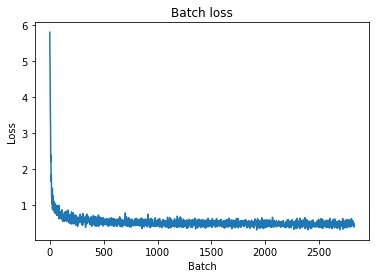

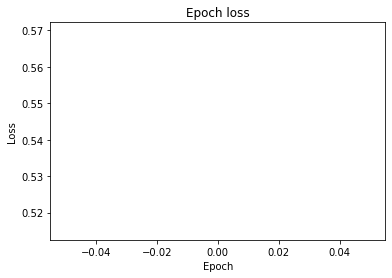

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, the the athe the the the the the the the the the the the the the the there the the the the the the the the the the the the the the the the the the the the the the the the the the the the the there the there there the the the the the the the the the the the the the the the the the the the there the there the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thathe the the the athe there the the the the there the the thathe thathe the the the the the the thathe the the there the the the the the the the so the the the the the the the the the the the thathe the the the the the the the s the the the the the an the ano the the the the the the the there the the there the the s the

100%|██████████| 2826/2826 [33:45<00:00,  1.39it/s]


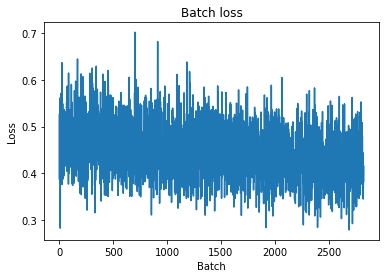

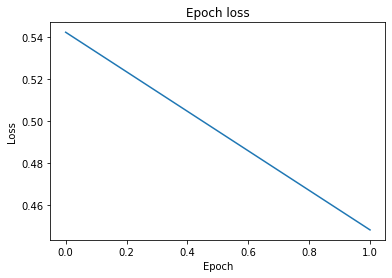

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, an the the the sould the the the streat and the the the the the the some the and the the the the stren the the the the the some the the the the the the the the sthe the sthe the the the the sthe trere the the sthe the the the the the the the the the there the sthe the the sthe the the sthe the the the the there sthe sthe the the sthe the the the the the there the the the the the the the sthe the the the sthe sthere the sthe sthe sthe the the the t the the the sthe the the the the the st the the the s sthe the the the the sthe sthe the the the sthe sthe sthe the sthe sthe the the the sthere s sthe the the the the the the the the stherere sthere sthe s s t st s s s sthe sthe s sthe sthe sthe the s sthe the s d d d derere de the sthe t st st sthe sthe there stherere sthe s s the the win win wo an the the d the s s s s s the s there sthe s s theren sthe s 

100%|██████████| 2826/2826 [33:53<00:00,  1.39it/s]


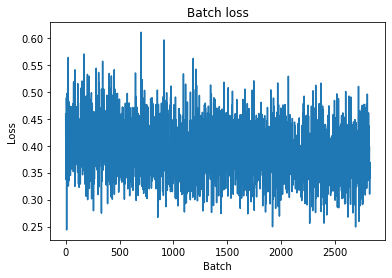

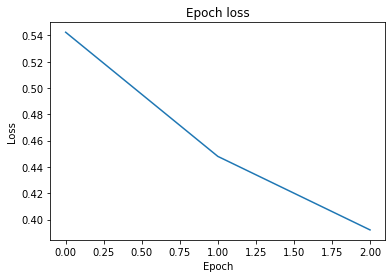

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, you do with the see the sart and the some the start to start the the start to the the the sart to the the the start and the the the the see the the to stome the the the some the the the the the stime the the the the the stis the to the the the the the the the the the sto the the the the the the the the the the the sthe the the the the the the the sto the the the the sthe the sthe the the sthe sthe the sthe sto sthe the sthe sthe sthe to st to the the the the the sthe the sthe sthe sthe the s the the sthe sthe the sthe sthe s sthe sthe sthe sthe sthe sthe sthe they the s the the the they sthe sthe s the the sthe s sthey the sthe stherere sthe sthe s s sthe s sthe s sthe sthe s s s s stheno sthin s sthe sthe is wandende s winde woure s s s s s s they wourenourende wan sthe sthe winde woure wonoure s the s the the the the the the s s the the the s d they 

100%|██████████| 2826/2826 [33:53<00:00,  1.39it/s]


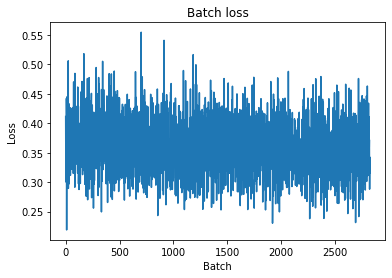

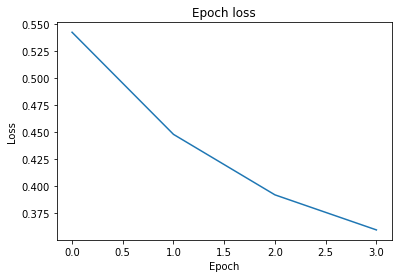

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? I would to some that see the some the same the some the same to the some that some the some that stating the some the some the the some the compent of the startion the the some the some the the some the some the the the sart the some the the the the soff the the the the stist the the the sthe the speme the the the the the the the sthe the the sthe the sthe sthe tist stis st sthe the sto sthe sthe sthe sthe s stis the ton stis wis the sthe s the s the the then the sthe the s the the the sthe sthe the s the sthe sthe sthe s sthe sthe sthe s sthe the sthe the the the sthey sthe s the sthe thend the s sthende s s therenderen s s sthe s s sthe sthe s s sthen s sthis s s s stherere s sthindendere s s in windende s s winde s s thenon thenden s s s sthey there s thenderende winonononde winde t win win t win the s win s s s the thede s s s the thedey s s s therendedede s s thin s s s s s indeandeande s s s s s s

100%|██████████| 2826/2826 [33:51<00:00,  1.39it/s]


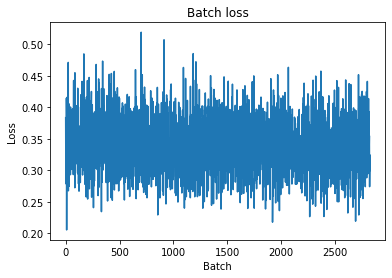

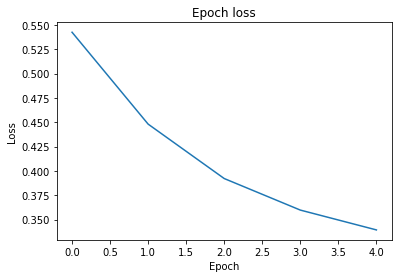

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, you can the code the code the company the company and the start the company the company the company the company and the start the start then the start and the the start the start the stince the the conter the the conter the the the conter the the stat the the stime the stat the stime the the the stime the the the spere the the the the the the sthe sthe the the the the the sthe sthe te the sthe sthe sthe sthe sthe sthe sthe stis sthe t tis then win the the the sthe the the the sthe sthe the the the s the sthe then the sthe sthe sthe sthe sthe sthe sthe sthe sthe sthe sthe the the they sthe sthe sthe the the sthend sthe sthend s s sthereren s s sthe s sthend sthen s s sthenden s s s sthe win sthey sthendey stinde s s winde win wind wind s s s sthendende s s sthendede s s sthen windey win windey win win win win win win the s win win s the they s win s s t

100%|██████████| 2826/2826 [33:56<00:00,  1.39it/s]


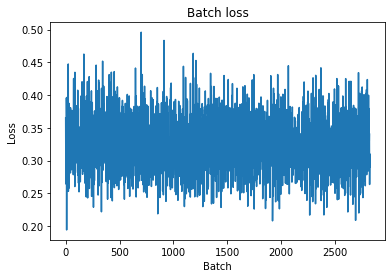

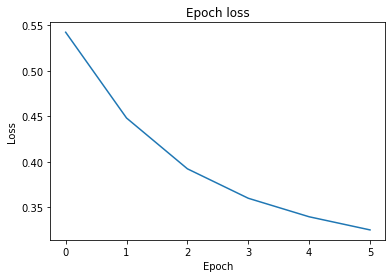

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, you do you want to the start and the start the start the same to company the start the contraction and the company the company to start the start the start the start the same the same to start the stime the stated the same the still the stime the some the some the still sting the the stime start the stinge the the the stempe the the sthe the sthe stis ste the sthe the the sthe the the st sthempe the st sthe stis ste ste stis s sthe stin the tin the the s the the sthe the sthe sthe s sthe the s the s then the sthe sthe s sthe s sthe sthen sthe sthe the s the sthey sthe s they the they the s sthe the sthe sthe sthe s sthe sthe sthend sthe sthe s s s s s sthenden sthe s s sthin s s s sthendon s sthende tinde s s stinde s sthe s s s s sthe s s stinde sthendendey sthey thende the win win win win win s the s they the then the s s the s s s thendende s s the 

100%|██████████| 2826/2826 [33:51<00:00,  1.39it/s]


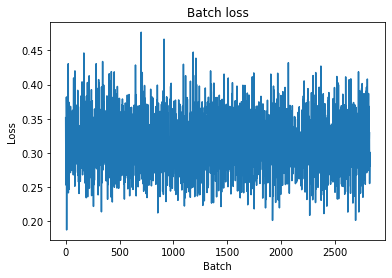

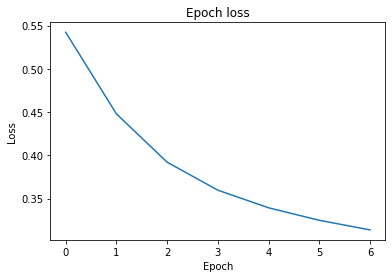

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, I would a second and a complete the company and the start the contract to construction and the control in the company the same to start the same to start the same to do the same to start the start the same to start the same the same to see the some the some the state the some the stime state the some the stime stime the sthe sthe sout the ste spee the the stime ste the sthe ste the ste sto sto se sto sto ste s seande s seand stite te te the to the the s sthe s sthe ste sthe s sthe s sthe s s the the s sthe sthe ston s s sthe s sthe sthe s sthe s sthe sthe s sthey s sthey the they s sthey sthe s sthe sthe sthe s s sthen s sthe s sthe sthe s s s sthey s s sthende s s sthe s sthen s s s sthe s s sthen sthe stey s s sthe sthe s win s sthen s sthe s sthen s s sthen win sthe s s windey win win win win win s s s s they win win s s s s s sthe s sthe s s s sthe

100%|██████████| 2826/2826 [33:52<00:00,  1.39it/s]


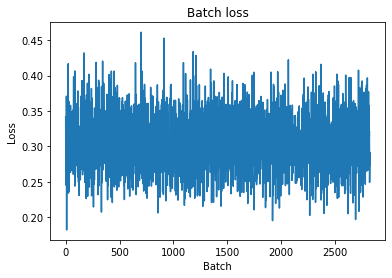

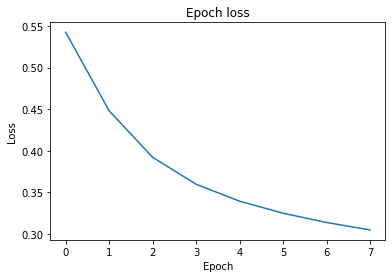

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? If you can see it work at to start and and the same that some that is a startic and and the same of the same and it is a some to start and there and the same to start the same that the same to start the same the same and the same the same the stime this soung the the same the sate some the sat some the some the sat the spey the stime ste the sthe the the spey seat the sthe sthe ste sthe ste ste sthey s stheype sthe te sthe sthe the sthey sthe s sthey sthe sthey sthe sthe s the then s sthey sthey sthe sthe s sthey sthe sthe sthe sthey s sthey sthey sthey s sthey sthey sthey s wandey sthen sthey s sthey they sthey sthey sthey s s sthey sthen s s sthey sthen sthey sthen sthen sthey win wey s sthey wendey wen wey s wey wen s stey they sthen sthendey wey sthey then wey wey weypen they wen wey wey then wen then wen then s they wendey sthey they sthey sthey sthey sthen sthey s s sthey s sthey sthey sthey sthen

 20%|█▉        | 555/2826 [06:40<27:16,  1.39it/s]


KeyboardInterrupt: 

In [23]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E9")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()